--- STEP 1: Loading Datasets ---
Data 1 Shape: (363, 5), Data 2 Shape: (414, 6)

--- STEP 2: Data Preprocessing and Transformation ---
Feature Matrix (X) Shape: (23, 64)
Target Variables (Y) Shape: (23, 8)

--- STEP 3: Scaling and Splitting Data ---

--- STEP 4: Defining and Training ANN Model (200 Epochs) ---


c:\Users\Kashan Computer\Desktop\Mahpara\rhino_env_tf311\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model Training Completed. Total Epochs Run: 200

--- STEP 5: Evaluation and Results ---

BEST VALIDATION METRICS (Epoch 189):
Validation Loss (MSE):    0.0853
Validation MAE:           0.1340

TEST SET EVALUATION (Using Best Weights):
Test Loss (MSE):          0.0853
Test Mean Absolute Error (MAE): 0.1340


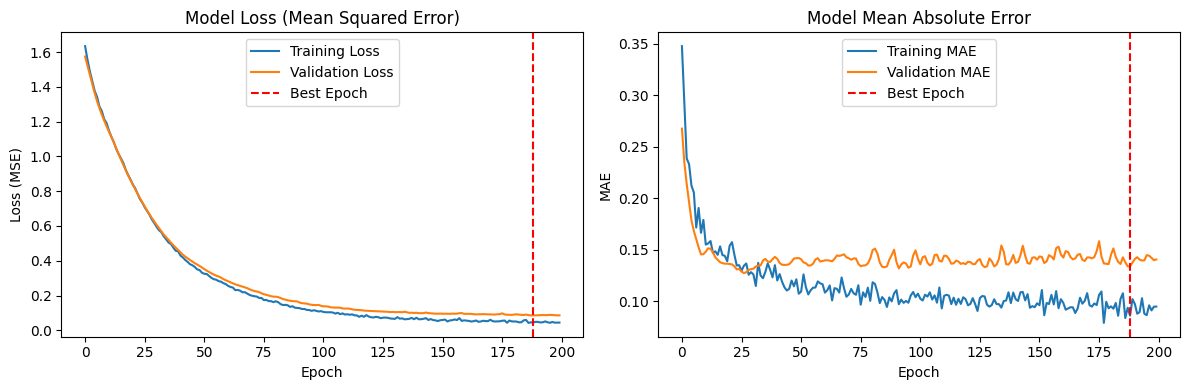


--- STEP 6: Future Prediction Code and Example ---

--- Predictions vs. Actual (First 5 Test Samples) ---
            Actual_Duration_Minutes_Visitor-Directed Approach  Actual_Evening_Visitor-Directed Approach  Actual_Frequency_Visitor-Directed Approach  Actual_Morning_Visitor-Directed Approach  Actual_Duration_Minutes_Lack of Response to Visitors  Actual_Evening_Lack of Response to Visitors  Actual_Frequency_Lack of Response to Visitors  Actual_Morning_Lack of Response to Visitors  Predicted_Duration_Minutes_Visitor-Directed Approach  Predicted_Evening_Visitor-Directed Approach  Predicted_Frequency_Visitor-Directed Approach  Predicted_Morning_Visitor-Directed Approach  Predicted_Duration_Minutes_Lack of Response to Visitors  Predicted_Evening_Lack of Response to Visitors  Predicted_Frequency_Lack of Response to Visitors  Predicted_Morning_Lack of Response to Visitors
Session_ID                                                                                                            

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
import tensorflow as tf
import pickle

# Set seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# =================================================================
# STEP 1: Load Datasets
# =================================================================
print("--- STEP 1: Loading Datasets ---")
file_1_name = "White_Rhino_Data_Empty_Lines_Removed.csv"
file_2_name = "White_Rhinoceros_Structured_Dataset.csv"

df1 = pd.read_csv(file_1_name)
df2 = pd.read_csv(file_2_name)
print(f"Data 1 Shape: {df1.shape}, Data 2 Shape: {df2.shape}")

# =================================================================
# STEP 2: Data Preprocessing and Feature Engineering (FIXED)
# =================================================================
print("\n--- STEP 2: Data Preprocessing and Transformation ---")

df = df2.copy()
df['Duration_Minutes'] = df['Duration_Minutes'].fillna(0)

# EXPERT FIX 1: Convert all numerical columns to float explicitly for NumPy consistency
numerical_cols = ['Morning', 'Evening', 'Frequency', 'Duration_Minutes']
df[numerical_cols] = df[numerical_cols].astype(float)

unique_behaviors_count = df['BEHAVIOR'].nunique()
df['Session_ID'] = (df.index // unique_behaviors_count)

df_wide = df.pivot_table(
    index='Session_ID',
    columns='BEHAVIOR',
    values=['Morning', 'Evening', 'Frequency', 'Duration_Minutes'],
    aggfunc='sum'
).fillna(0)
df_wide.columns = ['_'.join(map(str, col)).strip() for col in df_wide.columns.values]

interaction_VDA = [col for col in df_wide.columns if 'Visitor-Directed Approach' in col]
interaction_LKR = [col for col in df_wide.columns if 'Lack of Response to Visitors' in col]
Y_cols = interaction_VDA + interaction_LKR

X_cols = [col for col in df_wide.columns if col not in Y_cols]
X = df_wide[X_cols]
Y = df_wide[Y_cols]

print(f"Feature Matrix (X) Shape: {X.shape}")
print(f"Target Variables (Y) Shape: {Y.shape}")

# =================================================================
# STEP 3: Scaling and Splitting Data
# =================================================================
print("\n--- STEP 3: Scaling and Splitting Data ---")

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42
)

scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_Y = MinMaxScaler()
Y_train_scaled = scaler_Y.fit_transform(Y_train)
Y_test_scaled = scaler_Y.transform(Y_test)

# =================================================================
# STEP 4: Advanced Deep Learning Model Definition and Training (FIXED)
# =================================================================
print("\n--- STEP 4: Defining and Training ANN Model (200 Epochs) ---")

input_dim = X_train_scaled.shape[1]
output_dim = Y_train_scaled.shape[1]

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=25,        # Patience thodi barhayi gayi
    restore_best_weights=True 
)

# Define the Sequential ANN Model with L1 Regularization and increased capacity
model = Sequential([
    # Hidden Layer 1: More neurons + L1 Regularization
    Dense(128, activation='relu', input_shape=(input_dim,), 
          kernel_regularizer=regularizers.l1(0.001), name='Hidden_1'), # L1 used here
    Dropout(0.3), 
    
    # Hidden Layer 2: More neurons + L1 Regularization
    Dense(64, activation='relu', 
          kernel_regularizer=regularizers.l1(0.001), name='Hidden_2'), # L1 used here
    Dropout(0.3),
    
    # Hidden Layer 3
    Dense(32, activation='relu', name='Hidden_3'), # Thode zyada neurons
    
    # Output Layer (Regression)
    Dense(output_dim, name='Output')
])

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mae']
)

EPOCHS = 200
BATCH_SIZE = 4

history = model.fit(
    X_train_scaled,
    Y_train_scaled,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test_scaled, Y_test_scaled),
    callbacks=[early_stopping],
    verbose=0
)
print(f"Model Training Completed. Total Epochs Run: {len(history.history['loss'])}")

# =================================================================
# STEP 5: Evaluation and Results (WITH GRAPHS)
# =================================================================
print("\n--- STEP 5: Evaluation and Results ---")

loss, mae = model.evaluate(X_test_scaled, Y_test_scaled, verbose=0)

best_val_loss_epoch = np.argmin(history.history['val_loss'])
best_val_loss = history.history['val_loss'][best_val_loss_epoch]
best_val_mae = history.history['val_mae'][best_val_loss_epoch]

print(f"\nBEST VALIDATION METRICS (Epoch {best_val_loss_epoch + 1}):")
print(f"Validation Loss (MSE):    {best_val_loss:.4f}")
print(f"Validation MAE:           {best_val_mae:.4f}")
print("\nTEST SET EVALUATION (Using Best Weights):")
print(f"Test Loss (MSE):          {loss:.4f}")
print(f"Test Mean Absolute Error (MAE): {mae:.4f}")

# Plotting the Training History (GRAPHS/CHARTS)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axvline(best_val_loss_epoch, color='r', linestyle='--', label='Best Epoch')
plt.title('Model Loss (Mean Squared Error)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.axvline(best_val_loss_epoch, color='r', linestyle='--', label='Best Epoch')
plt.title('Model Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show() # Display the graphs

# =================================================================
# STEP 6: Future Prediction Code and Example
# =================================================================
print("\n--- STEP 6: Future Prediction Code and Example ---")

# Rounding logic setup
frequency_cols = [col for col in Y.columns if 'Frequency' in col or 'Morning' in col or 'Evening' in col]
duration_cols = [col for col in Y.columns if 'Duration' in col]

# --- Example Prediction (Comparison on Test Data) ---
predictions_scaled = model.predict(X_test_scaled, verbose=0)
predictions_corrected = np.maximum(0, predictions_scaled)
predictions = scaler_Y.inverse_transform(predictions_corrected)

predictions_df = pd.DataFrame(predictions, columns=Y.columns, index=Y_test.index)
predictions_df[frequency_cols] = predictions_df[frequency_cols].round(0).astype(int)
predictions_df[duration_cols] = predictions_df[duration_cols].round(2)

print("\n--- Predictions vs. Actual (First 5 Test Samples) ---")
comparison_df = Y_test.head().copy()
comparison_df.columns = [f'Actual_{col}' for col in comparison_df.columns]
predictions_df.columns = [f'Predicted_{col}' for col in predictions_df.columns]
final_comparison_df = pd.concat([comparison_df, predictions_df.head(5)], axis=1)
print(final_comparison_df.to_string())


# --- Single 'Future' Observation Prediction ---
new_data_point = X_test.iloc[0:1].copy() 
new_data_point_scaled = scaler_X.transform(new_data_point.astype(float)) # Ensure float type

future_prediction_scaled = model.predict(new_data_point_scaled, verbose=0)
future_prediction_corrected = np.maximum(0, future_prediction_scaled)
future_prediction = scaler_Y.inverse_transform(future_prediction_corrected)

future_prediction_df = pd.DataFrame(
    future_prediction,
    columns=Y.columns,
    index=['New_Future_Session']
)

future_prediction_df[frequency_cols] = future_prediction_df[frequency_cols].round(0).astype(int)
future_prediction_df[duration_cols] = future_prediction_df[duration_cols].round(2)

print("\n--- Prediction for a New (Future) Observation ---")
print(future_prediction_df.to_string())

# =================================================================
# NEW STEP 7 (PREVIOUSLY UNNUMBERED): Save Feature Statistics
# =================================================================
print("\n--- NEW STEP: Saving Feature Statistics for Flask App ---")

# Calculate min, max, and mean for the non-target features (X)
feature_stats = {
    'mean': X.mean().to_dict(),
    'max': X.max().to_dict(),
    'min': X.min().to_dict()
}

stats_file_name = "rhino_feature_stats.pkl"
with open(stats_file_name, 'wb') as file:
    pickle.dump(feature_stats, file)
print(f"Feature statistics saved successfully as '{stats_file_name}'")

# =================================================================
# STEP 7: Expert Scenario Analysis (Real Future Prediction Simulation)
# =================================================================
print("\n--- STEP 7: Real Future Prediction Simulation (Expert Scenario Analysis) ---")

X_mean = X.mean()

# 1. Scenario A: Low Activity & High Rest (Rhino is bored or relaxed)
scenario_A = X_mean.copy()
scenario_A['Duration_Minutes_Resting'] = X['Duration_Minutes_Resting'].max() 
scenario_A['Frequency_Roaming (outdoor enclosure)'] = X['Frequency_Roaming (outdoor enclosure)'].min()
scenario_A['Frequency_Foraging'] = X['Frequency_Foraging'].min()

# 2. Scenario B: High Morning Activity & Hunger (Rhino is active and alert)
scenario_B = X_mean.copy()
scenario_B['Morning_Foraging'] = X['Morning_Foraging'].max() 
scenario_B['Evening_Resting'] = X['Evening_Resting'].min() 
scenario_B['Frequency_Roaming (outdoor enclosure)'] = X['Frequency_Roaming (outdoor enclosure)'].max()

# 3. Scenario C: Average Baseline (Neutral day)
scenario_C = X_mean.copy() 

X_future_scenarios = pd.DataFrame([scenario_A, scenario_B, scenario_C],
                        index=['Scenario A (Low Activity/High Rest)', 
                               'Scenario B (High Active Morning)', 
                               'Scenario C (Average Baseline)'])

print(f"Created {len(X_future_scenarios)} hypothetical future scenarios.")

# Prediction Process for Future Scenarios
X_future_scaled = scaler_X.transform(X_future_scenarios.astype(float))

future_prediction_scaled = model.predict(X_future_scaled, verbose=0)
future_prediction_corrected = np.maximum(0, future_prediction_scaled)
future_prediction = scaler_Y.inverse_transform(future_prediction_corrected)

future_prediction_df_scenarios = pd.DataFrame(
    future_prediction,
    columns=Y.columns,
    index=X_future_scenarios.index
)

# Apply final rounding
future_prediction_df_scenarios[frequency_cols] = future_prediction_df_scenarios[frequency_cols].round(0).astype(int)
future_prediction_df_scenarios[duration_cols] = future_prediction_df_scenarios[duration_cols].round(2)


print("\n--- Expert Analysis: Real Future Prediction (Scenario Results) ---")
print(future_prediction_df_scenarios.to_string())

# Final Actionable Insight (for report)
print("\n--- Actionable Insight ---")
key_results = future_prediction_df_scenarios[['Frequency_Visitor-Directed Approach']]
highest_interaction_scenario = key_results['Frequency_Visitor-Directed Approach'].idxmax()
highest_interaction_value = key_results['Frequency_Visitor-Directed Approach'].max()

print(f"Prediction: Rhino's highest interaction is predicted in the '{highest_interaction_scenario}' with {highest_interaction_value} approaches.")

if highest_interaction_value > 10:
    print("\n* Recommendation: High Activity days (Scenario B) require increased visitor management to ensure safety and reduced stress on the rhino.")
elif highest_interaction_value < 5:
     print("\n* Recommendation: Low Activity days (Scenario A) suggest low visitor engagement. Consider enrichment schedules during these times.")
else:
     print("\n* Recommendation: Moderate interaction. Continue current management protocols.")


# =================================================================
# STEP 8: Model Deployment - Saving the Model and Scalers (FIXED)
# =================================================================
print("\n--- STEP 8: Model Deployment - Saving the Model and Scalers ---")

# 1. Save the Keras model (structure, weights, and optimizer state)
model_name = "rhino_interaction_ann_model.keras" 
try:
    model.save(model_name)
    print(f"ANN Model saved successfully as '{model_name}'")
except Exception:
    # Fallback to older .h5 format
    model_name = "rhino_interaction_ann_model.h5"
    model.save(model_name)
    print(f"ANN Model saved successfully as '{model_name}' (using .h5 fallback)")


# 2. Save the scalers (Crucial for future predictions)
scaler_X_name = "rhino_scaler_X.pkl"
scaler_Y_name = "rhino_scaler_Y.pkl"

with open(scaler_X_name, 'wb') as file:
    pickle.dump(scaler_X, file) # <--- This line caused the NameError
print(f"Scaler X (Features) saved successfully as '{scaler_X_name}'")

with open(scaler_Y_name, 'wb') as file:
    pickle.dump(scaler_Y, file)
print(f"Scaler Y (Targets) saved successfully as '{scaler_Y_name}'")

print("\nDeployment ke liye zaroori files ab tayyar hain! (Model aur Scalers)")